Different but good tutorial: https://medium.com/neuralspace/bayesian-neural-network-series-post-1-need-for-bayesian-networks-e209e66b70b2

This script was modified from: https://github.com/paraschopra/bayesian-neural-network-mnist

In [46]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [49]:
%matplotlib inline

In [50]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [51]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [53]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [54]:
log_softmax = nn.LogSoftmax(dim=1)

In [55]:
log_softmax = nn.LogSoftmax(dim=1)
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [56]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [57]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [58]:
import time

In [ ]:
net = NN(28*28, 1024, 10)

Epoch  0  Loss  93.53048930794398
Epoch  1  Loss  87.77834157382647
Epoch  2  Loss  86.71001484467189
Epoch  3  Loss  86.26367556694349
Epoch  4  Loss  85.94834001158078
Time Elapsed: 1574228498.32783

Epoch  0  Loss  85.75145101911227
Time Elapsed [epochs=1: 1574234993s]



In [95]:
tic=time.time()
num_iterations = 1
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        print(f'epoch {j} progress: {100 * batch_id*128 / len(train_loader.dataset):.1f}%', end='\r')
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

print(f'Time Elapsed [epochs={num_iterations}: {time.time():.0f}s]')

Epoch  0  Loss  85.75145101911227
Time Elapsed [epochs=1: 1574234993s]


Prediction when network is forced to predict
accuracy: 77 % [time=6.7, n=1]
accuracy: 84 % [time=11.9, n=2]
accuracy: 86 % [time=16.9, n=3]
accuracy: 88 % [time=28.5, n=5]

In [98]:
num_samples = [1,2,3,5,10,20,50]
acc = [] 

def predict(x, n):
    sampled_models = [guide(None, None) for _ in range(n)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')

for num in num_samples: 
    correct = 0
    total = 0
    tic = time.time()
    for j, data in enumerate(test_loader):
        images, labels = data
        labels = labels.numpy()
        predicted = predict(images.view(-1,28*28), num)
        correct += (predicted == labels).sum().item()
        total += len(predicted)
    print("accuracy: %d %% [time=%.1f, n=%d]" % (100 * correct / total, time.time()-tic, num))

Prediction when network is forced to predict
accuracy: 77 % [time=6.8, n=1]
accuracy: 84 % [time=15.2, n=2]
accuracy: 86 % [time=21.5, n=3]
accuracy: 88 % [time=28.5, n=5]
accuracy: 90 % [time=54.1, n=10]
accuracy: 90 % [time=106.8, n=20]
accuracy: 90 % [time=259.1, n=50]


In [25]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [82]:
def give_uncertainities(x, n):
    sampled_models = [guide(None, None) for _ in range(n)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

def predict_with_certainty(x, n, a=0.2):
    y = give_uncertainities(x, n)
    pred = [-1]*y.shape[1]
    for n in range(y.shape[1]):
        obs = y[:,n,:]
        for c in range(obs.shape[1]): 
            probs = np.exp(obs[:,c]) # log_probs 
            median = np.percentile(probs, 50) # take median
            if median > a:
                pred[n]=c # choose the class
                break # for simplicity, just take the first val > a 
    return np.array(pred)

In [97]:
N_SAMPLES = 100
ALPHA = 0.9 # threshold for certainty, 0.2 -> 95% acc, 957 skipped 
print(f'Prediction when network is NOT forced to predict [Number of samples used for inference: {N_SAMPLES}]')
correct = 0
total = 0
skipped = 0
tic = time.time()
for j, data in enumerate(test_loader):
    images, labels = data
    labels = labels.numpy()
    predicted = predict_with_certainty(images.view(-1,28*28), N_SAMPLES, a=ALPHA)
    correct += (predicted == labels).sum().item()
    total += np.sum(predicted>=0) # only include the guesses our model chose to make in the total
    skipped += np.sum(predicted<0)
    print(f'progress: {j*128}/{len(test_loader.dataset)} [acc={correct/total*100:.2f} | skipped={skipped} ({skipped/total:.2f})]', end='\r')

print()
print("accuracy: %d %% [time=%.1f, n=%d]" % (100 * correct / total, time.time()-tic, N_SAMPLES))
print(f'number of obs skipped: {skipped} [{skipped/total}]')

Prediction when network is NOT forced to predict [Number of samples used for inference: 100]
progress: 9984/10000 [acc=96.07 | skipped=1161 (0.13)]
accuracy: 96 % [time=634.4, n=100]
number of obs skipped: 1161 [0.13134970019232944]


In [26]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [27]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [38]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions = 0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/(predicted_for_images+0.0001))
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [29]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))


Prediction when network can refuse
Total images:  10000
Skipped:  1173
Accuracy when made predictions: 95 %


In [30]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

Real:  6


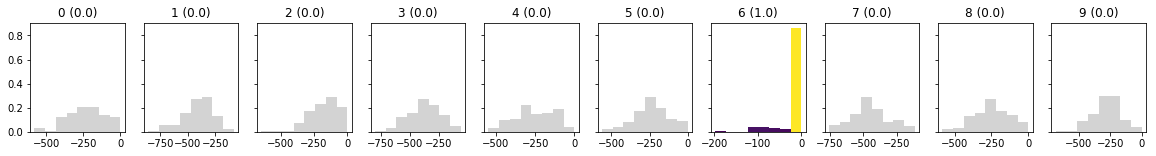

Correct


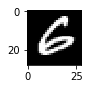

Real:  8


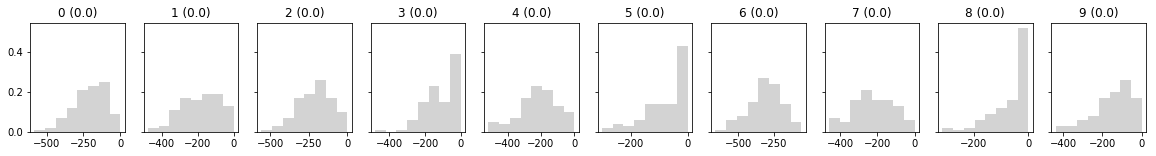

Undecided.


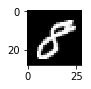

Real:  6


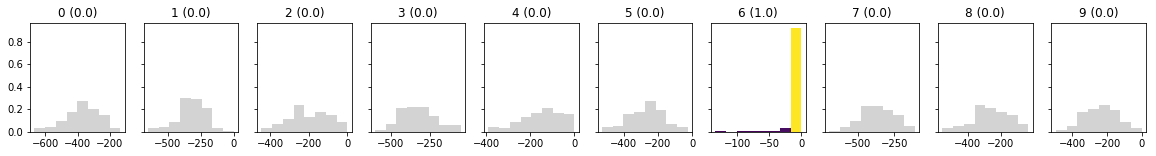

Correct


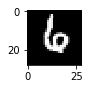

Real:  9


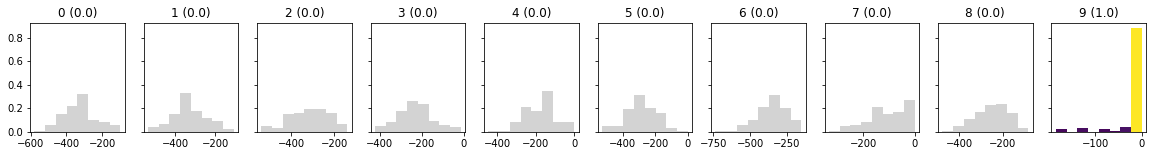

Correct


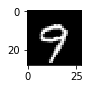

Real:  1


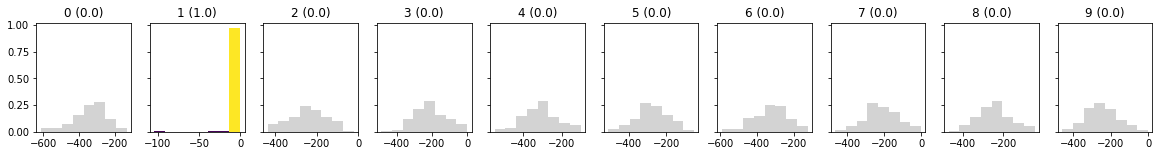

Correct


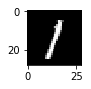

Summary
Total images:  5
Predicted for:  4
Accuracy when predicted:  1.0


(5, 4.0, 4)

In [34]:
test_batch(images[:5], labels[:5])

In [35]:
# generate random data

images_random = torch.rand(5,28,28)
labels_random = torch.randint(0,10, (5,))

Real:  4


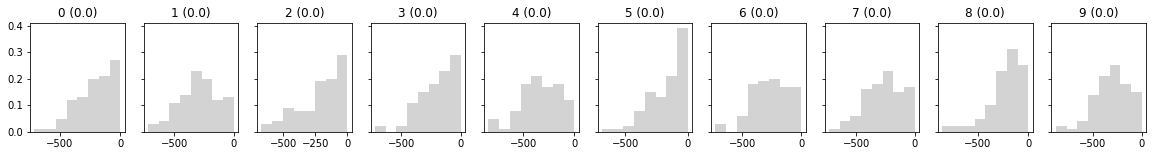

Undecided.


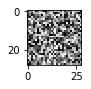

Real:  0


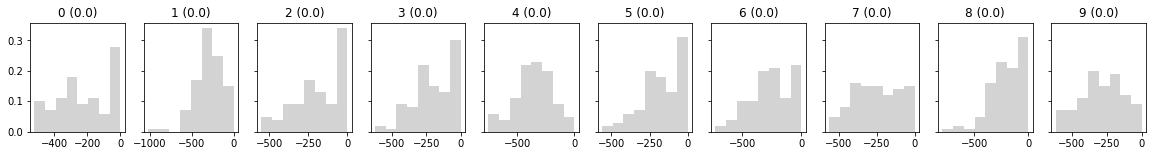

Undecided.


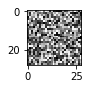

Real:  4


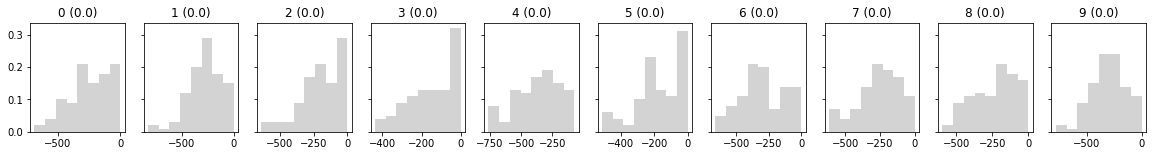

Undecided.


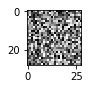

Real:  3


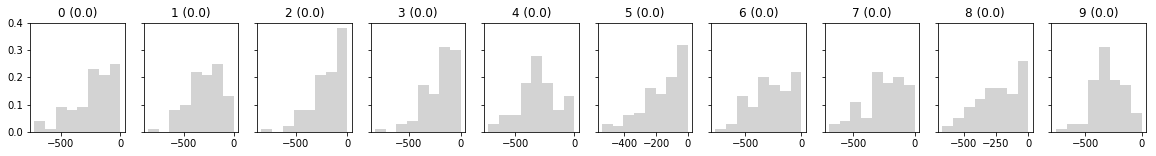

Undecided.


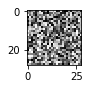

Real:  3


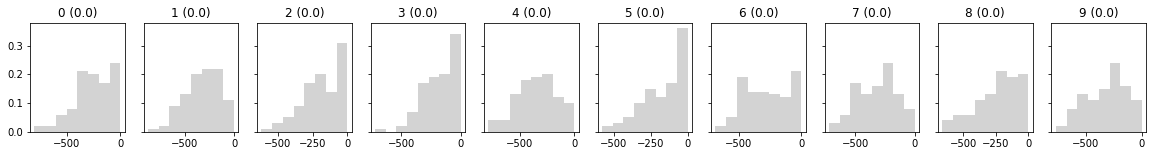

Undecided.


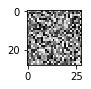

Summary
Total images:  5
Predicted for:  0
Accuracy when predicted:  0.0


(5, 0, 0)

In [39]:
test_batch(images_random, labels_random)

In [40]:
class data_loader(Dataset):
	def __init__(self, root):
		Images, Y = [], []
		folders = os.listdir(root)
		folders = folders[1:]

		for folder in folders:
            
			folder_path = os.path.join(root, folder)
			print(folder_path)
            
            
            
			for ims in os.listdir(folder_path):

				img_path = os.path.join(folder_path, ims)
				Images.append(np.array(imread(img_path)))
				Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
				
		data = [(x, y) for x, y in zip(Images, Y)]
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		img = self.data[index][0]

		# 8 bit images. Scale between 0, 1
		img = img.reshape(1, 28, 28) / 255

		# Input for Conv2D should be Channels x Height x Width
		img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
		label = self.data[index][1]
		return (img_tensor, label)

In [41]:
# NOT Mnist data

test_dataset_notmnist = data_loader('not-mnist')
test_loader_notmnist = DataLoader(test_dataset_notmnist, batch_size=128, shuffle=True)

not-mnist\B
not-mnist\C
not-mnist\D
not-mnist\E


C:\anaconda-3.5.2.0\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


not-mnist\F
not-mnist\G
not-mnist\H
not-mnist\I
not-mnist\J


In [42]:
# Prediction when network can decide not to predict

print('Prediction on not-MNIST when network can refuse')
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader_notmnist):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)

Prediction on not-MNIST when network can refuse
Total images:  362
Skipped:  289


In [43]:
dataiter_notmnist = iter(test_loader_notmnist)
images_notmnist, labels_notmnist = dataiter_notmnist.next()

Real:  1


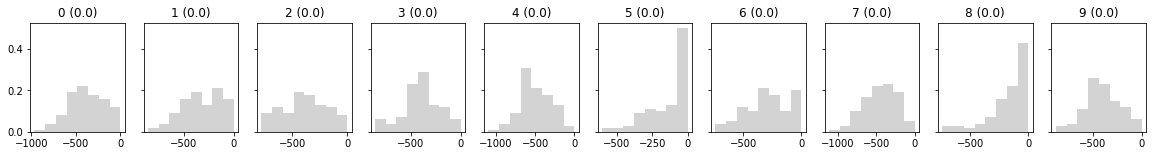

Undecided.


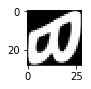

Real:  7


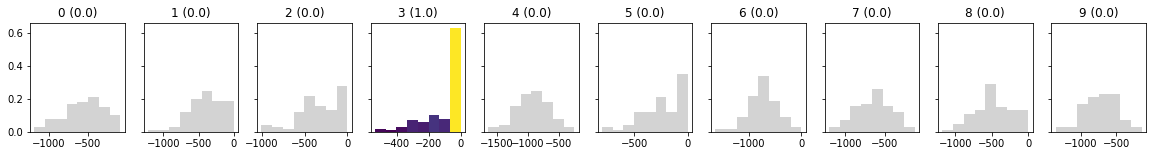

Incorrect :()


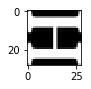

Real:  9


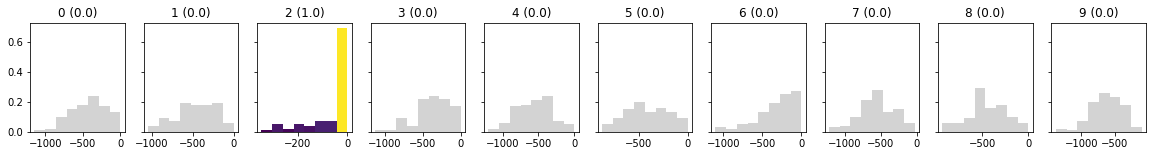

Incorrect :()


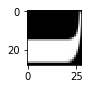

Real:  7


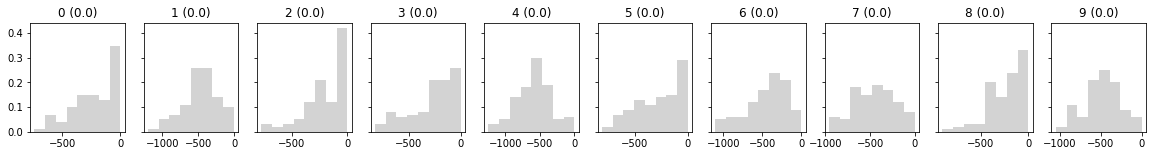

Undecided.


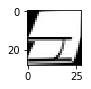

Real:  6


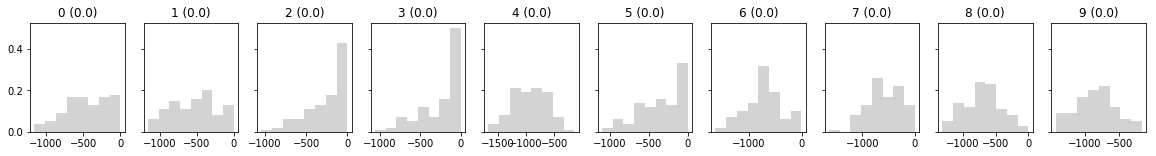

Undecided.


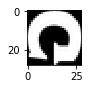

Real:  9


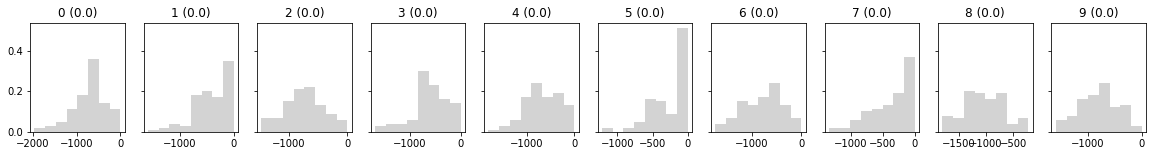

Undecided.


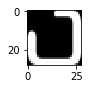

Real:  1


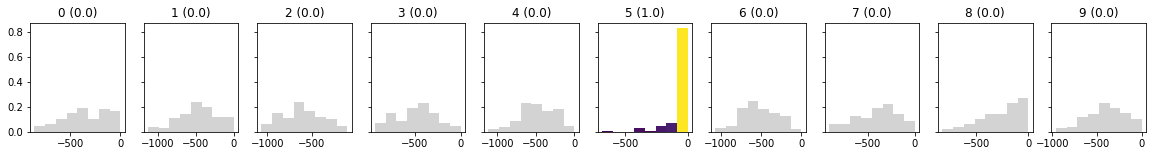

Incorrect :()


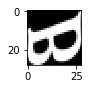

Real:  5


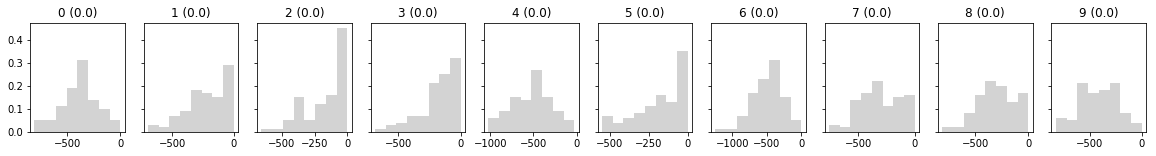

Undecided.


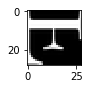

Real:  5


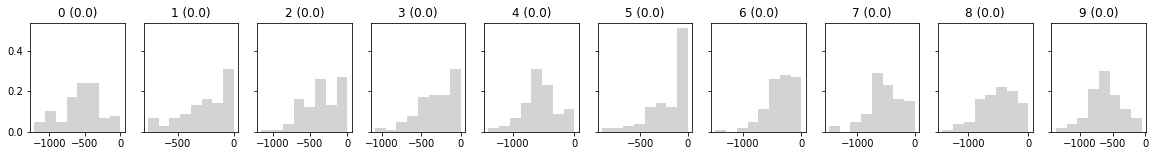

Undecided.


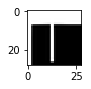

Real:  7


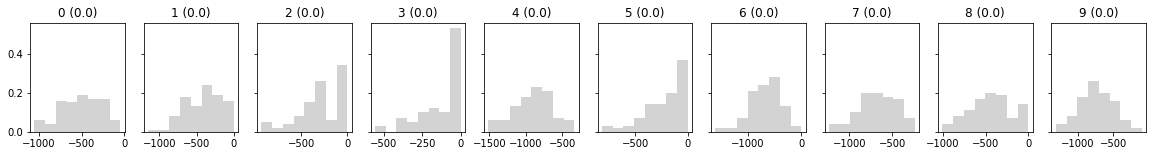

Undecided.


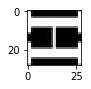

Real:  3


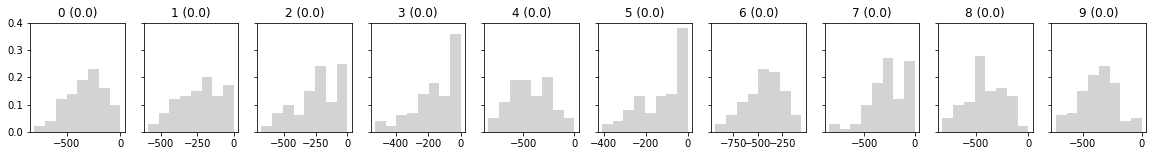

Undecided.


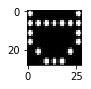

Real:  5


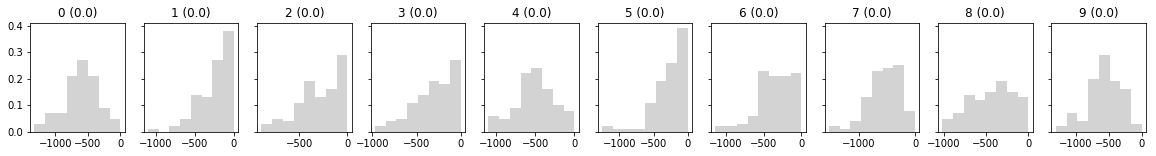

Undecided.


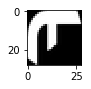

Real:  1


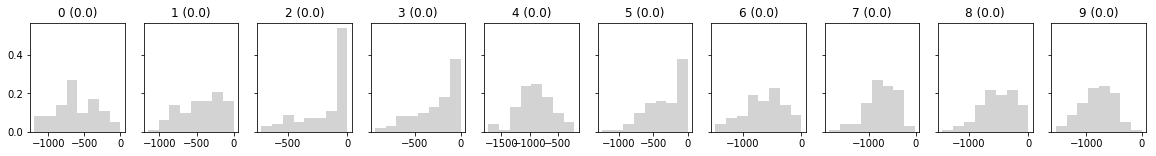

Undecided.


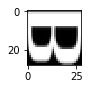

Real:  9


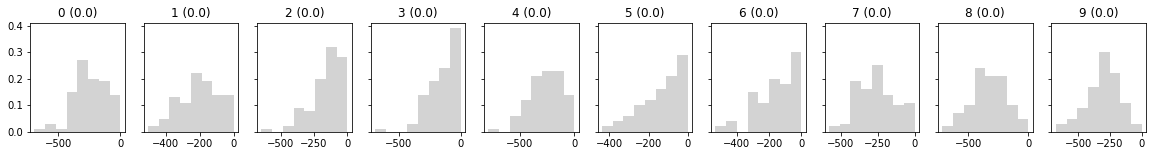

Undecided.


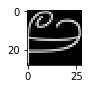

Real:  9


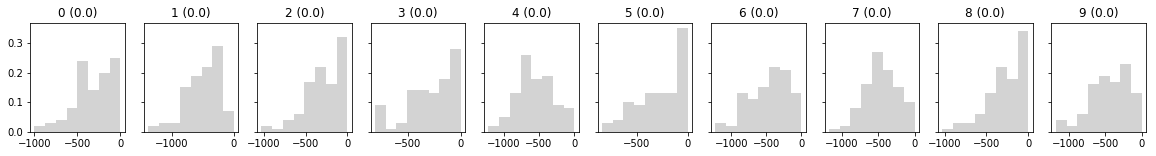

Undecided.


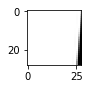

Real:  6


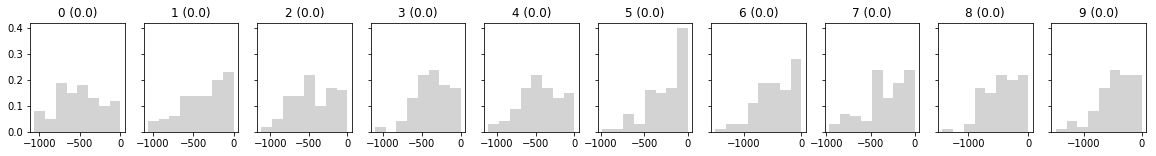

Undecided.


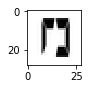

Real:  2


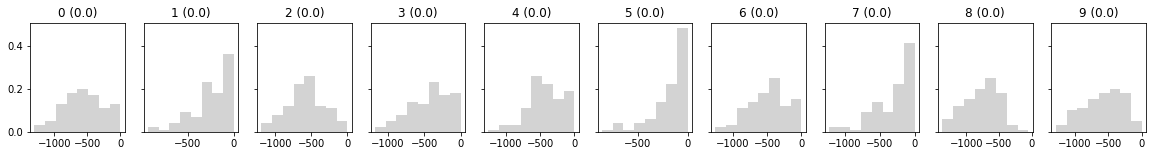

Undecided.


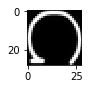

Real:  5


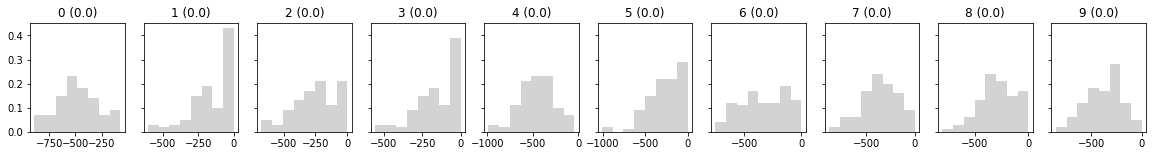

Undecided.


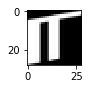

Real:  1


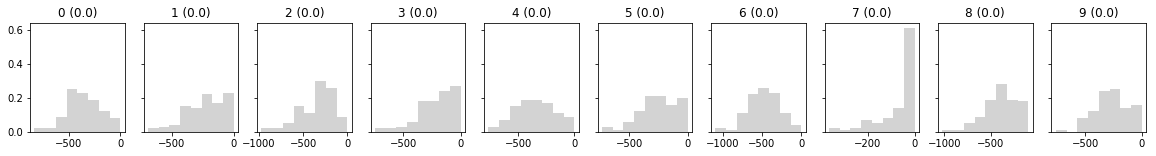

Undecided.


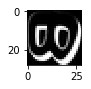

Real:  2


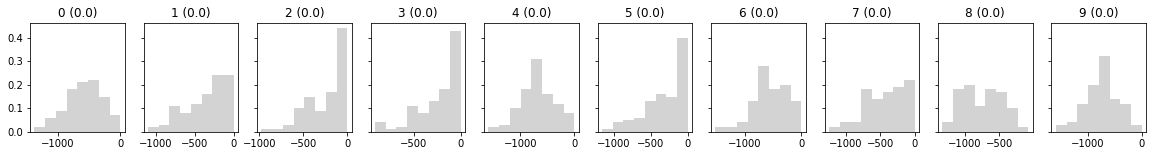

Undecided.


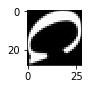

Summary
Total images:  20
Predicted for:  3
Accuracy when predicted:  0.0


(20, 0, 3)

In [45]:
test_batch(images_notmnist[:20], labels_notmnist[:20])